In [35]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from category_encoders.target_encoder import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
import xgboost as xgb
from sklearn.model_selection import learning_curve
import seaborn as sns

from yellowbrick.model_selection import FeatureImportances

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import r2_score

import time

# Importation et visualisation des données

In [36]:
data = pd.read_csv('data_traitement.csv')

In [37]:
data.shape

(3365, 21)

In [38]:
data.columns

Index(['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'Age', 'NumberOfPropertyUse',
       'Steam', 'Electricity', 'Gas', 'LargestPropertyUseType',
       'PrimaryPropertyType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType', 'Neighborhood', 'BuildingType',
       'TotalGHGEmissions'],
      dtype='object')

In [39]:
data.head()

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),Age,...,Steam,Electricity,Gas,LargestPropertyUseType,PrimaryPropertyType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Neighborhood,BuildingType,TotalGHGEmissions
0,12.0,88434.0,0.0,88434.0,88434.0,0.0,0.0,60.0,7226362.5,96.0,...,1,1,1,Hotel,Hotel,None,None,DOWNTOWN,NonResidential,249.98
1,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,61.0,8387933.0,27.0,...,0,1,1,Hotel,Hotel,Parking,Restaurant,DOWNTOWN,NonResidential,295.86
2,41.0,956110.0,196718.0,759392.0,756493.0,0.0,0.0,43.0,72587024.0,54.0,...,1,1,1,Hotel,Hotel,None,None,DOWNTOWN,NonResidential,2089.28
3,10.0,61320.0,0.0,61320.0,61320.0,0.0,0.0,56.0,6794584.0,97.0,...,1,1,1,Hotel,Hotel,None,None,DOWNTOWN,NonResidential,286.43
4,18.0,175580.0,62000.0,113580.0,123445.0,68009.0,0.0,75.0,14172606.0,43.0,...,0,1,1,Hotel,Hotel,Parking,Swimming Pool,DOWNTOWN,NonResidential,505.01


In [40]:
df = data.copy()

In [41]:
#Avec EnergyStarScore
df = df[['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'Age',
       'NumberOfPropertyUse', 'Steam', 'Electricity', 'Gas', 'LargestPropertyUseType', 'PrimaryPropertyType', 
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Neighborhood', 'BuildingType']]

# Préparation des données

## Features X et target y

In [42]:
X = df.drop(['SiteEnergyUse(kBtu)'] , axis=1)
y = df['SiteEnergyUse(kBtu)']

## Passage au log de y

<AxesSubplot:>

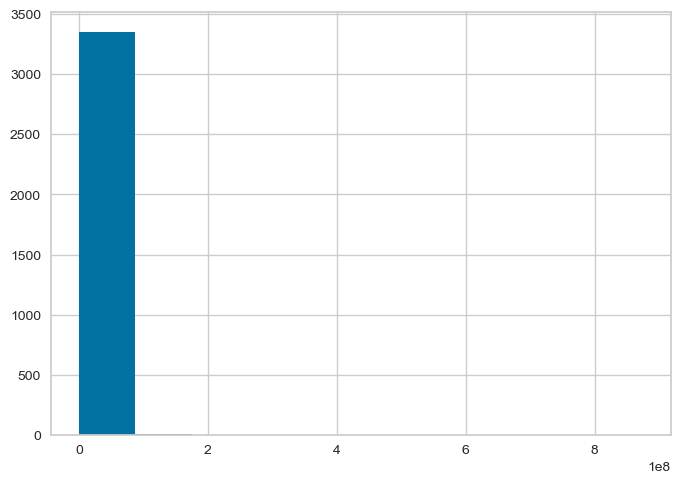

In [43]:
#Affichage de la distribution de y
y.hist()

On aimerait que y suivent une loi normale, pour cela on observe sa distribution lorsqu'on lui applique une transformation logarithmique. On compare donc les distributions du log classique, du log en base 2 et du log en base 10.

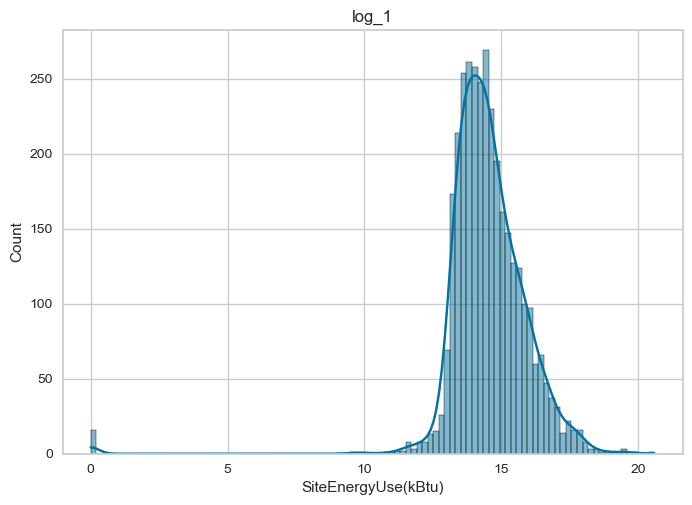

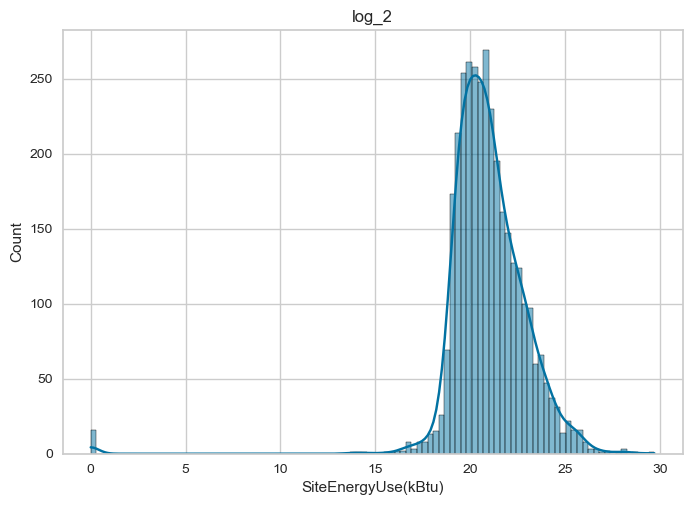

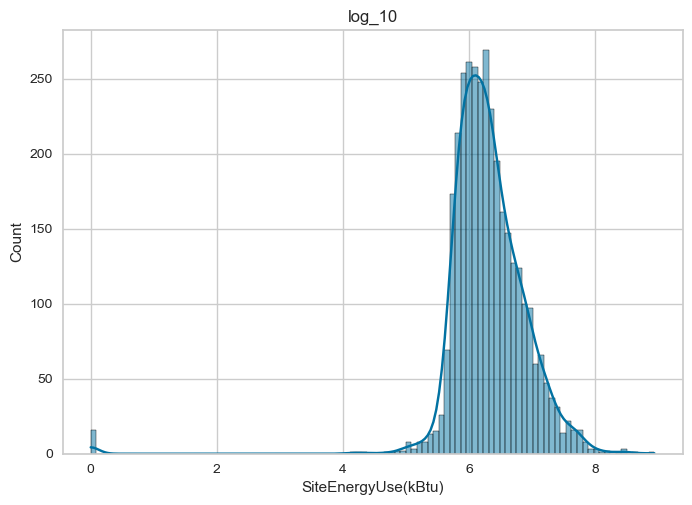

In [44]:
list_of_model = {"log_1": np.log1p(y),
                 "log_2": np.log2(1+y), 
                 "log_10": np.log10(1+y)
                }
for model in list_of_model.items():
    sns.histplot(data=model[1], kde=True).set(title=model[0])
    plt.show()

On observe que les 3 logarithmes permettent de donner à y une distribution normale. Cela est très important pour l'apprentissage du modèle. Pour départager les 3 transformations, on va se concentrer sur la variance apporter pour chacune des transformations. En effet, plus cette dernière est petite, mieux ce sera pour l'apprentissage de notre modèle.

In [45]:
for model in list_of_model.items():
    print(model[0],"a pour variance :", model[1].var())

log_1 a pour variance : 2.3458658582073766
log_2 a pour variance : 4.882612430872929
log_10 a pour variance : 0.44245774047809994


Le logarithme en base 10 est celui ayant la plus petite variance (10 fois plus petite qu'en log2 !). On décide donc d'appliquer cette transformation à y.

In [46]:
#Transformation de y
y = np.log10(1+y)

## Création des échantillons Train / Test

In [47]:
#Utilisation de la fonction train_test_split pour la création de X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [48]:
#Taille de l'échantillon pour l'entrainement
X_train.shape[0]

3028

In [49]:
#Taille de l'échantillon pour le test
X_test.shape[0]

337

## Preprocessing

On applique aux variables quantitatives un StandardScaler afin de les normalisées (et de réduire le poids des variables avec de "forte" valeurs sur celles ayant de "faibles" valeurs). On applique ensuite un TargetEncoder sur les variables qualitatives afin de les rendre numériques (et donc lisible par les modèles).

In [50]:
#Implémentation de la fonction make_column_transformer 
transformer = make_column_transformer((StandardScaler() , [
                'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)', 
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
                'ENERGYSTARScore', 'Age', 'NumberOfPropertyUse']), 
                                      (TargetEncoder(), [
                'Neighborhood', 'LargestPropertyUseType', 'PrimaryPropertyType', 'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType', 'BuildingType', 'Steam', 'Electricity', 'Gas']))

In [51]:
#Création de X_train_scaled par transformation de X_train
X_train_scaled = transformer.fit_transform(X_train, y_train)

In [52]:
#Création de X_test_scaled par transformation de X_test
X_test_scaled = transformer.transform(X_test)

# Modélisation

Afin de mesurer au mieux les performances de nos modèles (et donc de choisir les meilleurs pour notre apprentissage), on créer une fonction d'évaluation qui mesurera pour chaque modèle sa RMSE ainsi que son score R².

In [53]:
#Fonction d'évaluation
def evaluation(model):
    model.fit(X_train_scaled, y_train)
    print(type(model).__name__)
    print('R²:', model.score(X_test_scaled, y_test))
    print('RMSE : ', mean_squared_error(y_test, model.predict(X_test_scaled), squared=False))
    print('---------------------------')

In [54]:
#Création d'une liste de modèles
list_of_models = [
                  SGDRegressor(max_iter=1000, tol=1e-3),
                  Lasso(alpha=0.1),
                  ElasticNet(random_state=0),
                  Ridge(alpha=.5),
                  SVR(kernel='linear'),
                  SVR(),
                  KNeighborsRegressor(), 
                  RandomForestRegressor(random_state=0), 
                  GradientBoostingRegressor(random_state=0),
                  xgb.XGBRegressor(verbosity=0), 
                  BaggingRegressor(random_state=0),
                  DummyRegressor(strategy="mean")
                  ]

In [55]:
#Evaluation des performances des modèles
for model in list_of_models:
    evaluation(model)

SGDRegressor
R²: -0.15337903586167467
RMSE :  0.6842183706081562
---------------------------
Lasso
R²: 0.22310965724619058
RMSE :  0.561550172788331
---------------------------
ElasticNet
R²: -8.634433641230288e-05
RMSE :  0.6371291161897785
---------------------------
Ridge
R²: 0.49809895022165884
RMSE :  0.45135447822749286
---------------------------
SVR
R²: 0.5222296045175736
RMSE :  0.4403706047298241
---------------------------
SVR
R²: 0.5916518272894263
RMSE :  0.40712147565920237
---------------------------
KNeighborsRegressor
R²: 0.7692619621671355
RMSE :  0.306033029369442
---------------------------
RandomForestRegressor
R²: 0.8100542469126928
RMSE :  0.2776665074464353
---------------------------
GradientBoostingRegressor
R²: 0.8460137360320985
RMSE :  0.2500055758774558
---------------------------
XGBRegressor
R²: 0.8651957066097749
RMSE :  0.23391634312784862
---------------------------
BaggingRegressor
R²: 0.7888900891973742
RMSE :  0.2927271570231848
-------------------

On choisit de sélectionner les 4 meilleurs modèles (sur la base du score R²). On prends alors le Gradient Boosting, le Random Forest, le Bagging et XGBoost.

# Optimisation

Maintenant qu'on a nos 4 modèles, on choisit de les optimiser avec RandomizedSearchCV et GridSearchCV afin de trouver les meilleurs hyperparamètres pour notre modélisation. Pour ce faire on suit la méthodologie suivante pour chaque modèle : 
- On sélectionne plusieurs hyperparamètres dont on veut connaitre les performances
- On implémente GridSearchCV si le modèle à un temps de calcule court (sinon on utilise RandomizedSearchCV)
- Lorsqu'on trouve une solution satisfaisante, on va chercher dans son proche voisinage afin de trouver une solution encore plus performante

## XGB Regressor

In [56]:
#Sélection du modèle XGB
model = xgb.XGBRegressor()

In [57]:
params = {
           'max_depth': [10],
           'n_estimators': [170],
           'learning_rate': [0.07],
           'colsample_bytree': [1],
           'subsample' : [0.2]
           
}

           #'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
           #'xgbregressor__n_estimators': [100, 500, 1000],
           #'xgbregressor__colsample_bytree': [0.3, 0.7],
           #'xgbregressor__subsample' : [0.6, 0.8, 1]

In [58]:
#Utilisation de GridSearchCV avec 5 folds et scoring R²
grid_xgb = GridSearchCV(model, params, cv=5, scoring='r2', verbose=2)

#Calcul du temps
start = time.time()

#grid_xgb = RandomizedSearchCV(model, params, n_iter=50, scoring='neg_root_mean_squared_error', verbose=2)

#Fit de GridSearchCV sur les données d'entrainement
grid_xgb.fit(X_train_scaled, y_train)

#Meilleurs paramètres
print(grid_xgb.best_params_)

#Meilleurs scores R²
print(grid_xgb.best_score_)

#Calcul de la prédiction par le meilleur modèle sélectionner par GridSearchCV
y_pred = grid_xgb.predict(X_test_scaled)

#Calcul de la RMSE
print('RMSE : ', type(xgb.XGBRegressor()).__name__, mean_squared_error(y_test, grid_xgb.predict(X_test_scaled), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche par grille
print(f'Temps d\'exécution : {elapsed:.2}ms')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=1, learning_rate=0.07, max_depth=10, n_estimators=170, subsample=0.2; total time=   1.5s
[CV] END colsample_bytree=1, learning_rate=0.07, max_depth=10, n_estimators=170, subsample=0.2; total time=   1.1s
[CV] END colsample_bytree=1, learning_rate=0.07, max_depth=10, n_estimators=170, subsample=0.2; total time=   1.0s
[CV] END colsample_bytree=1, learning_rate=0.07, max_depth=10, n_estimators=170, subsample=0.2; total time=   1.8s
[CV] END colsample_bytree=1, learning_rate=0.07, max_depth=10, n_estimators=170, subsample=0.2; total time=   4.2s
{'colsample_bytree': 1, 'learning_rate': 0.07, 'max_depth': 10, 'n_estimators': 170, 'subsample': 0.2}
0.7496273353204183
RMSE :  XGBRegressor 0.2100612659652663
Temps d'exécution : 1.9e+01ms


In [59]:
#Calcul du score R² par le meilleur modèle sélectionné
r2_score(y_test, y_pred)

0.8912887349691069

## Random Forest Regressor

In [60]:
#Sélection du modèle de RandomForest
model = RandomForestRegressor() 

In [61]:
params = {'n_estimators' : [1000],
          'max_depth' : [None],
          'min_samples_leaf' : [1],
          'max_features' : ['auto'],
          'min_samples_split' : [5]
          }


In [62]:
#Calcul du temps
start = time.time()

#Utilisation de RandomizedSearchCV avec 5 folds et scoring R²
grid_rf = RandomizedSearchCV(model, params, cv=5, n_iter=12, scoring='r2', verbose=2)

#grid_rf = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', verbose=2)

#Fit du modèle sur les données d'entrainement
grid_rf.fit(X_train_scaled, y_train)

#Meilleurs paramètres trouvés par le modèle
print(grid_rf.best_params_)

#Calcul de la prédiction par le meilleur modèle sélectionné par RandomizedSearchCV
y_pred = grid_rf.predict(X_test_scaled)

#Calcul de la RMSE
print('RMSE : ', type(model).__name__, mean_squared_error(y_test, grid_rf.predict(X_test_scaled), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

C:\Users\moham\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=12. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  39.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  29.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  32.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  52.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=  45.7s
{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None}
RMSE :  RandomForestRegressor 0.2596661492924756
Temps d'exécution : 2.5e+02ms


In [63]:
#Score R² sur les données test par le meilleur modèle sélectionné 
r2_score(y_test, y_pred)

0.8338833104223862

## Gradient Boosting Regressor

In [64]:
#Sélection du modèle de GradientBoosting
model = GradientBoostingRegressor()

In [65]:
params = {'loss' : ['squared_error'],
          'learning_rate' : [1e-1], 
          'max_depth' : [3], 
          'n_estimators' : [100],
          'criterion' : ['friedman_mse'],
          'min_samples_split' : [2],
          'min_samples_leaf' : [1],
          'min_weight_fraction_leaf': [0],
          'max_depth' : [3],
          'min_impurity_decrease' : [1e-1],
          'max_features' : ['auto'],
          'verbose' : [0],        
         }

In [66]:
#Utilisation de GridSearchCV avec 5 folds et score R²
grid_gb = GridSearchCV(model, params, cv=5, scoring='r2')

#Calcul du temps
start = time.time()

#grid_gb = RandomizedSearchCV(model, params, random_state=0, n_iter=1, scoring='r2')

#Fit sur les données d'entrainement
grid_gb.fit(X_train_scaled, y_train)

#Meilleurs hyperparamètres sélectionnés par GridSearchCV
print(grid_gb.best_params_)

#Prédiction du modèle sélectionné par GridSearchCV 
y_pred = grid_gb.predict(X_test_scaled)

#Calcul de la RMSE
print('RMSE : ', type(model).__name__, mean_squared_error(y_test, grid_gb.predict(X_test_scaled), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'auto', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 100, 'verbose': 0}
RMSE :  GradientBoostingRegressor 0.2476034368173417
Temps d'exécution : 8.2ms


In [67]:
#Calcul du score R² par le meilleur modèle sélectionné
r2_score(y_test, y_pred)

0.8489586253407968

## Bagging Regressor

In [68]:
#Sélection du modèle de Bagging
model = BaggingRegressor()

In [69]:
params = {'base_estimator' : [None],
          'n_estimators' : [100],
          'max_samples': [0.75],
          'max_features' : [0.85],
       
          } 
#'bootstrap_features' : [True, False] 
#'bootstrap' : [True, False],

In [70]:
#Calcul du temps
start = time.time()

#Utilisation de GridSearchCV avec 5 folds et score R²
grid_br = GridSearchCV(model, params, cv=5, scoring='r2', verbose=2, refit=True)

#grid_br = RandomizedSearchCV(model, params, random_state=0, n_iter=200, scoring='r2', verbose=2)

#Fit sur les données d'entrainement
grid_br.fit(X_train_scaled, y_train)

#Meilleurs hyperparamètres sélectionnés par GridSearchCV
print(grid_br.best_params_)

#Prédiction du modèle sélectionné par GridSearchCV
y_pred = grid_br.predict(X_test_scaled)

#Calcul de la RMSE
print('RMSE : ', type(BaggingRegressor()).__name__, mean_squared_error(y_test, grid_br.predict(X_test_scaled), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END base_estimator=None, max_features=0.85, max_samples=0.75, n_estimators=100; total time=   2.9s
[CV] END base_estimator=None, max_features=0.85, max_samples=0.75, n_estimators=100; total time=   3.0s
[CV] END base_estimator=None, max_features=0.85, max_samples=0.75, n_estimators=100; total time=   2.9s
[CV] END base_estimator=None, max_features=0.85, max_samples=0.75, n_estimators=100; total time=   2.9s
[CV] END base_estimator=None, max_features=0.85, max_samples=0.75, n_estimators=100; total time=   3.8s
{'base_estimator': None, 'max_features': 0.85, 'max_samples': 0.75, 'n_estimators': 100}
RMSE :  BaggingRegressor 0.28967921226531795
Temps d'exécution : 2.2e+01ms


In [71]:
#Calcul du score R² sur les données test par le modèle sélectionné
r2_score(y_test, y_pred)

0.7932634549504749

# Comparaison des performances 

On ré-entraine nos modèle et on évalue leurs MSE, MAE, score R² et temps de calcul.

In [72]:
# Import required libraries for performance metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

import xgboost as xgb
from sklearn.model_selection import cross_validate

#Define dictionary with performance metrics
scoring = {'MSE':make_scorer(mean_absolute_error), 
           'MAE':make_scorer(mean_squared_error),
           'R2':make_scorer(r2_score)}
     
#Perform cross-validation to each machine learning regressor
xgb = cross_validate(grid_xgb.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
rfr = cross_validate(grid_rf.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
gbr = cross_validate(grid_gb.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
br = cross_validate(grid_br.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
dummy =  cross_validate(DummyRegressor(strategy="mean"), X_train_scaled, y_train, cv=5, scoring=scoring)

On affiche et compare les différentes métriques afin de sélectionner le meilleur modèle.

In [73]:
#Create a data frame with the models perfoamnce metrics scores
models_scores_table = pd.DataFrame({'XGBoost Regressor':[xgb['test_MSE'].mean(),
                                                               xgb['test_MAE'].mean(),
                                                               xgb['test_R2'].mean(),
                                                               np.log10(1+xgb['fit_time'].mean())],
                                        
                                        'RandomForest Regressor':[rfr['test_MSE'].mean(),
                                                               rfr['test_MAE'].mean(),
                                                               rfr['test_R2'].mean(),
                                                               np.log10(1+rfr['fit_time'].mean())],
                                        
                                        'GradientBoosting Regressor':[gbr['test_MSE'].mean(),
                                                               gbr['test_MAE'].mean(),
                                                               gbr['test_R2'].mean(),
                                                               np.log10(1+gbr['fit_time'].mean())],
                                        
                                        'Bagging Regressor':[br['test_MSE'].mean(),
                                                               br['test_MAE'].mean(),
                                                               br['test_R2'].mean(),
                                                              np.log10(1+br['fit_time'].mean())],
                                   
                                        'Dummy Regressor' : [dummy['test_MSE'].mean(),
                                                               dummy['test_MAE'].mean(),
                                                               dummy['test_R2'].mean(),
                                                              np.log10(1+dummy['fit_time'].mean())]},
                                      
                                      index=['MSE', 'MAE', 'R2', 'Score Time'])
    
#Add 'Best Score' column
models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
models_scores_table.iloc[[0,1,3], 5] = models_scores_table.iloc[[0,1,3],:4].idxmin(axis=1)

models_scores_table

,XGBoost Regressor,RandomForest Regressor,GradientBoosting Regressor,Bagging Regressor,Dummy Regressor,Best Score
MSE,0.158305,0.156956,0.155277,0.163032,0.416125,GradientBoosting Regressor
MAE,0.111287,0.118804,0.111402,0.137374,0.446644,XGBoost Regressor
R2,0.749627,0.724256,0.749679,0.700804,-0.001826,GradientBoosting Regressor
Score Time,0.324899,1.777080,0.502676,0.811055,0.001215,XGBoost Regressor


On observe ici que sur les différentes métriques considérées XGBoost a les meilleurs scores.

<AxesSubplot:xlabel='index', ylabel='value'>

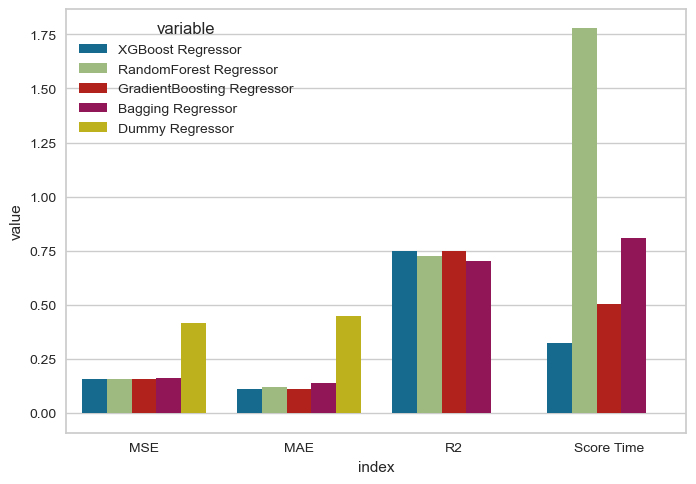

In [74]:
df_bar = models_scores_table.drop(['Best Score'],axis=1).reset_index().melt(id_vars=["index"])
sns.barplot(x="index", y="value", hue="variable", data=df_bar)

Les 4 modèles considérés bien qu'ayant des scores différents sont tout de même assez proches. Cependant le RandomForest et le Bagging possèdent un temps de calcul beaucoup trop long. Ils ne sont pas intéressant pour une modélisation sur une grande base de données. Le XGB est est meilleur en tout point (R², MSE, MAE et temps de calcul).

# Learning Curve

Il est intéressant de regarder comment se comporte nos courbe d'apprentissage. Ces dernières peuvent nous en apprendre sur le sur-apprentissage (ou sous apprentissage) de nos modèles. Ils peuvent également nous en apprendre sur les performances potentiels de nos modèles si on avait plus de données d'entrainement.

In [75]:
from sklearn.model_selection import learning_curve
import xgboost as xgb

In [76]:
models = {'XGBoost' : xgb.XGBRegressor(max_depth = 10, n_estimators = 170, learning_rate = 0.07, 
                                       colsample_bytree = 1, subsample = 0.2),
          'RandomForest' : RandomForestRegressor(n_estimators = 1000, max_depth = None,
                                       min_samples_leaf = 1, max_features = 'auto', min_samples_split = 5),
          'GradientBoosting' : GradientBoostingRegressor(loss = 'squared_error', learning_rate = 1e-1, max_depth = 3, 
                                       n_estimators = 100, criterion = 'friedman_mse', min_samples_split = 2,
                                       min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                       min_impurity_decrease = 1e-1, max_features = 'auto'),
          'Bagging' : BaggingRegressor(base_estimator = None, n_estimators = 100, max_samples = 0.75, 
                                       max_features = 0.85)}

In [77]:
def learning_c(model_name, model):
    
    N, train_score, val_score = learning_curve(model, X_train_scaled, y_train, cv=5, scoring= 'r2',
                                               train_sizes=np.linspace(0.2, 1, 5))
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.title(type(model).__name__)
    plt.legend()
    plt.show()

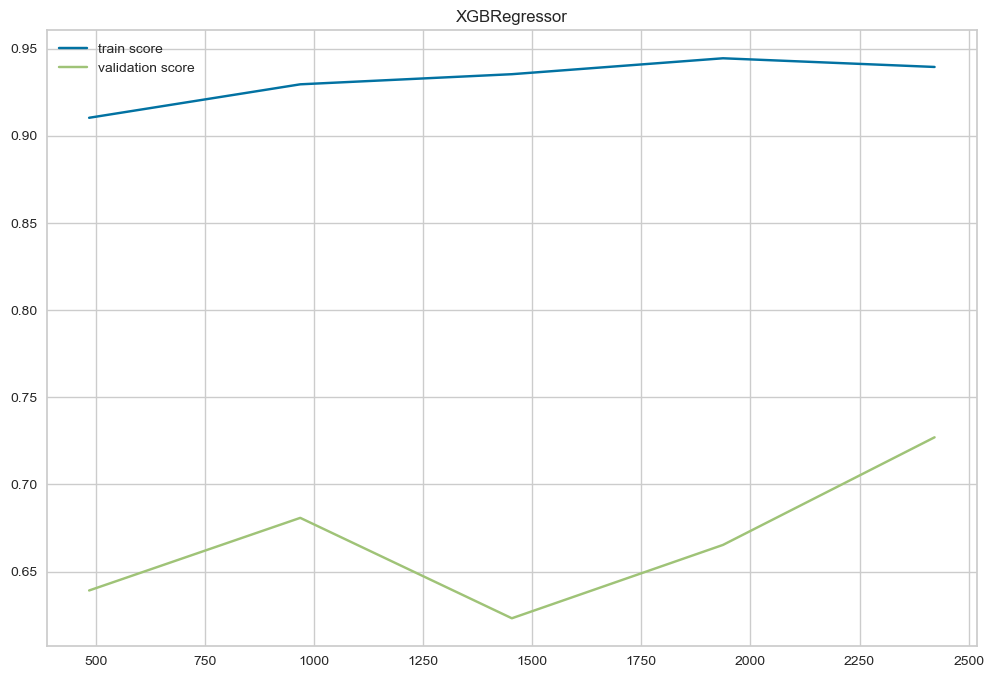

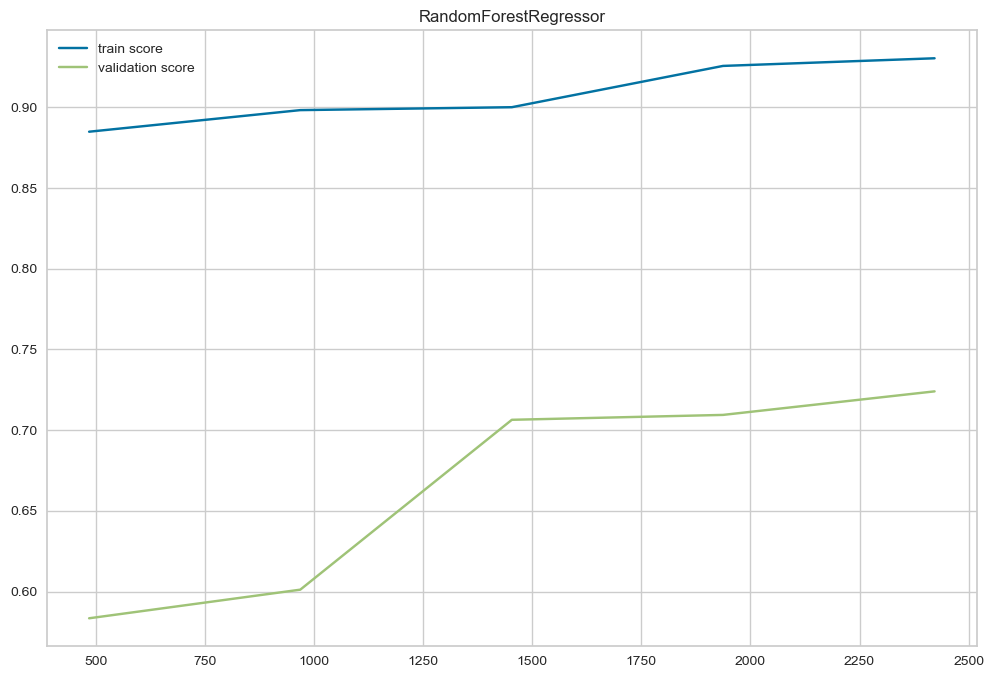

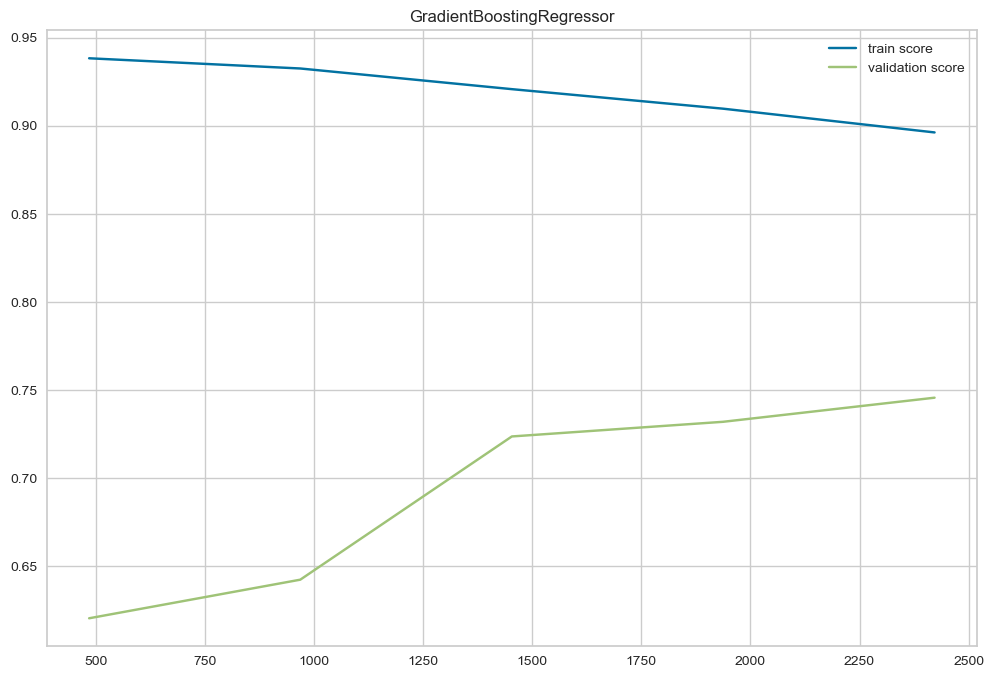

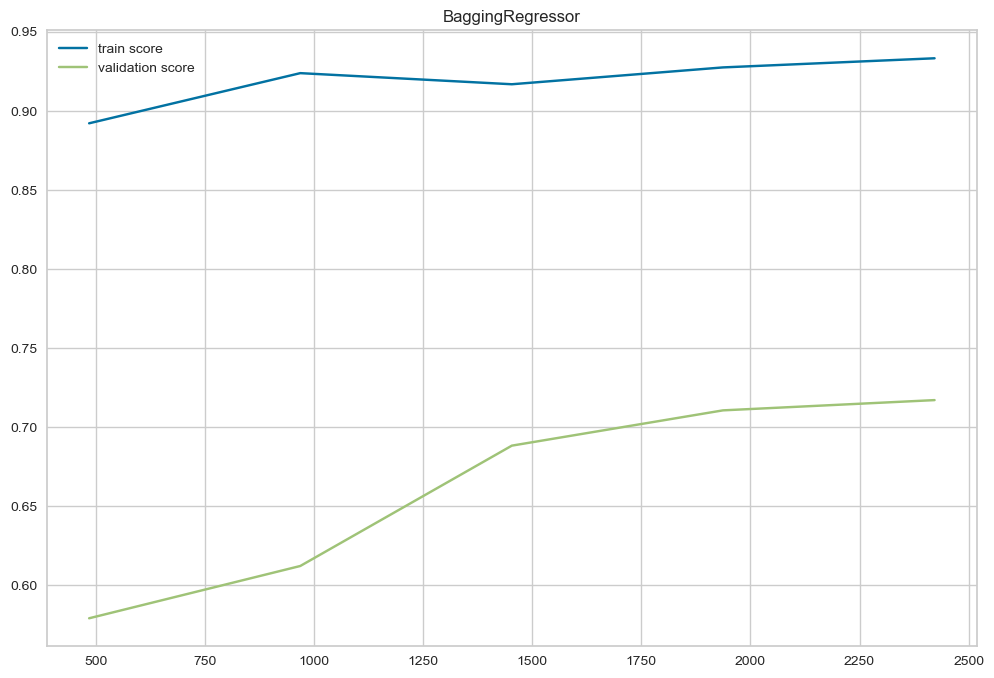

In [78]:
for model in models.items():
    learning_c(model[0], model[1])

- XGB : overfit et pourrait avoir un meilleur score R² avec plus de données.
- RandomForest : overfit et pourrait avoir un léger meilleur score R² avec plus de données.
- GradientBoosting : overfit moins que les autres et pourrait avoir un meilleur score R² avec plus de données
- Bagging : overfit et pourrait avoir un léger meilleur score R² avec plus de données.

# Importance des variables

On veut connaitre pour chaque modèle les variables les plus importantes à son apprentissage.

In [79]:
colonnes = ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 
 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Age', 'NumberOfPropertyUse', 
 'Neighborhood', 'LargestPropertyUseType', 'PrimaryPropertyType', 'SecondLargestPropertyUseType', 
 'ThirdLargestPropertyUseType', 'BuildingType', 'Steam', 'Electricity', 'Gas']

In [80]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=colonnes)

## XGB Regressor

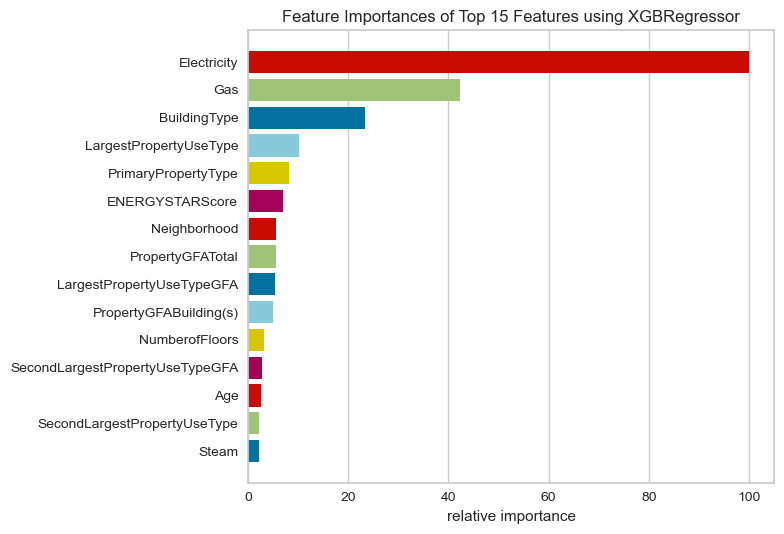

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using XGBRegressor'}, xlabel='relative importance'>

In [81]:
model = grid_xgb.best_estimator_
viz = FeatureImportances(model, topn=15)
viz.fit(X_train_scaled, y_train)
viz.show()

Note : ENERGYSTARScore se situe à la 6ème place des variables les plus importantes pour XGB. Il n'est pas déterminant mais permet quand même d'améliorer les performances de XGB.

## Random Forest Regressor

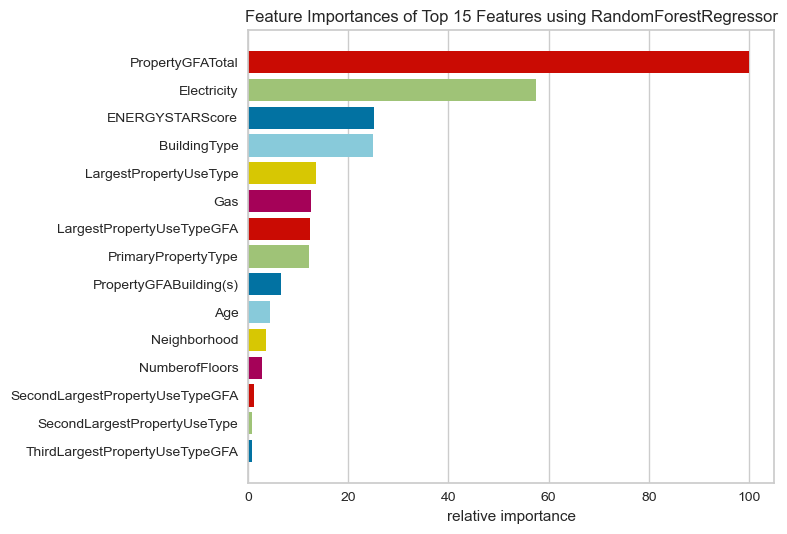

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [82]:
model = grid_rf.best_estimator_
viz = FeatureImportances(model, topn=15)
viz.fit(X_train_scaled, y_train)
viz.show()

Note : ENERGYSTARScore se situe ici à la 3ème position des variables les plus importantes pour le RandomForest, il est ici plus important que pour le XGB. L'enlever ici réduirait certainement de manière importante les performances du RandomForest.

## Gradient Boosting Regressor

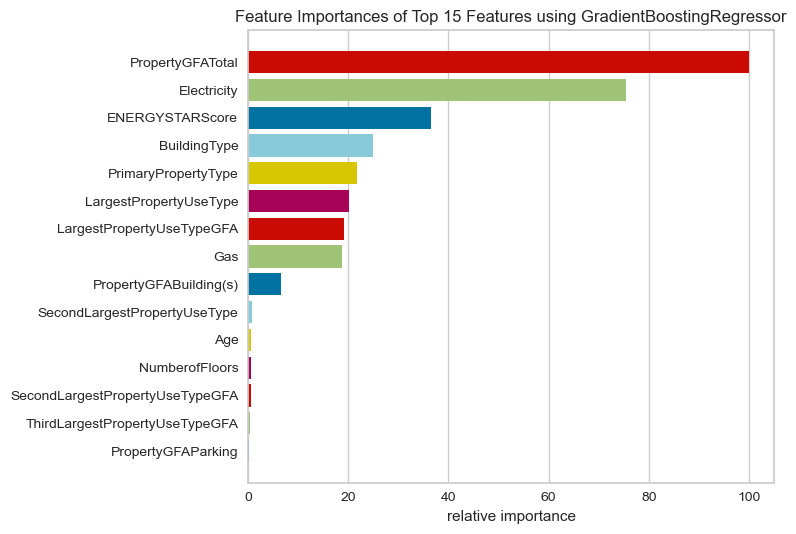

<AxesSubplot:title={'center':'Feature Importances of Top 15 Features using GradientBoostingRegressor'}, xlabel='relative importance'>

In [83]:
model = grid_gb.best_estimator_
viz = FeatureImportances(model, topn=15)
viz.fit(X_train_scaled, y_train)
viz.show()

Note : ENERGYSTARScore arrive ici à la 3ème position des variables les plus importantes. Cela est une position essentielle permettant au modèle d'avoir une aussi bonne performance.

## Bagging

In [118]:
model = grid_br.best_estimator_
feature_importances = np.mean([
    tree.feature_importances_ for tree in grid_br.best_estimator_
], axis=0)

C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(
C:\Users\moham\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not ha

<AxesSubplot:xlabel='importance', ylabel='var'>

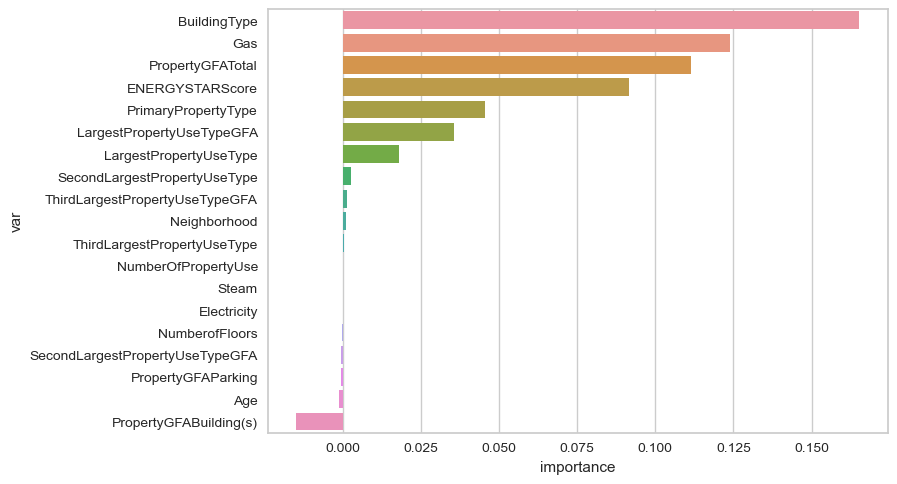

In [85]:
from sklearn.inspection import permutation_importance
model = BaggingRegressor()
# fit the model
model.fit(X_train_scaled, y_train)
# perform permutation importance
results = permutation_importance(model, X_test_scaled, y_test, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# plot feature importance
feature_importance = pd.DataFrame(data = {'var' : X_train_scaled.columns, 'importance' : importance})
sns.barplot(data = feature_importance, 
            y='var', 
            x='importance',
           order=feature_importance.sort_values(by='importance', ascending=False)['var'].values)

Note : Pour le Bagging l'ENERGYSTARScore est en 4ème place des features les plus important. Il est donc ici aussi très déterminant dans les performances de notre modèle.

# Intérêt de l'ENERGYSTARScore

Pour nous assurer de l'intérêt de l'ENERGYSTARScore, on décide de reproduire les mêmes étapes que précedemment mais cette fois ci en enlevant la variable ENERGYSTARScore. On observera ensuite les changements et on pourra conclure sur son intérêt dans notre sélection de variable.

In [93]:
import xgboost as xgb

In [94]:
#Suppression de ENERGYSTARScore dans les données d'entrainement / de test
X_train_ESS = X_train.drop(['ENERGYSTARScore'], axis=1)
X_test_ESS = X_test.drop(['ENERGYSTARScore'], axis=1)

In [95]:
#Implémentation de la fonction make_column_transformer 
transformer = make_column_transformer((StandardScaler() , [
                'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)', 
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
                'Age', 'NumberOfPropertyUse']), 
                                      (TargetEncoder(), [
                'Neighborhood', 'LargestPropertyUseType', 'PrimaryPropertyType', 'SecondLargestPropertyUseType', 
                'ThirdLargestPropertyUseType', 'BuildingType', 'Steam', 'Electricity', 'Gas']))

In [96]:
#Création de X_train_scaled par transformation de X_train
X_train_ESS = transformer.fit_transform(X_train_ESS, y_train)

In [97]:
#Création de X_test_scaled par transformation de X_test
X_test_ESS = transformer.transform(X_test_ESS)

In [98]:
#Création d'une fonction d'évaluation
def evaluation(model):
    model.fit(X_train_ESS, y_train)
    print(type(model).__name__)
    print('R²:', model.score(X_test_ESS, y_test))
    print('RMSE : ', mean_squared_error(y_test, model.predict(X_test_ESS), squared=False))
    print('---------------------------')

In [99]:
#Création d'une liste de modèles
list_of_models = [
                  SGDRegressor(max_iter=1000, tol=1e-3),
                  Lasso(alpha=0.1),
                  ElasticNet(random_state=0),
                  Ridge(alpha=.5),
                  SVR(kernel='linear'),
                  SVR(),
                  KNeighborsRegressor(), 
                  RandomForestRegressor(random_state=0), 
                  GradientBoostingRegressor(random_state=0),
                  xgb.XGBRegressor(verbosity=0), 
                  BaggingRegressor(random_state=0),
                  DummyRegressor(strategy="mean")
                  ]

In [100]:
#Evaluation des performances des modèles
for model in list_of_models:
    evaluation(model)

SGDRegressor
R²: 0.35648132814134104
RMSE :  0.5110804635730652
---------------------------
Lasso
R²: 0.18370956902452573
RMSE :  0.5756136133171066
---------------------------
ElasticNet
R²: -8.634433641230288e-05
RMSE :  0.6371291161897785
---------------------------
Ridge
R²: 0.43603903837942637
RMSE :  0.47844632707112783
---------------------------
SVR
R²: 0.46249309927182514
RMSE :  0.4670901681838029
---------------------------
SVR
R²: 0.5394490695644694
RMSE :  0.4323620185706332
---------------------------
KNeighborsRegressor
R²: 0.6763523632909115
RMSE :  0.3624473458427692
---------------------------
RandomForestRegressor
R²: 0.6616357365352785
RMSE :  0.3705961881872036
---------------------------
GradientBoostingRegressor
R²: 0.7111915189542553
RMSE :  0.34238416836850266
---------------------------
XGBRegressor
R²: 0.75038524409801
RMSE :  0.31830527159992267
---------------------------
BaggingRegressor
R²: 0.6927004058879579
RMSE :  0.3531747911932916
-------------------

# Optimisation

## XGB Regressor

In [122]:
import xgboost as xgb

In [123]:
#Sélection du modèle XGB
model = xgb.XGBRegressor()

In [124]:
params = {
           'max_depth': [4],
           'n_estimators': [550],
           'learning_rate': [0.02],
           'colsample_bytree': [0.85],
           'subsample' : [1]
           
}


In [141]:
#Utilisation de GridSearchCV avec 5 folds et score R²
grid_xgb = GridSearchCV(model, params, cv=5, scoring='r2', verbose=2)

#Calcul du temps
start = time.time()

#grid_xgb = RandomizedSearchCV(model, params, n_iter=1000, scoring='r2', verbose=2, refit=True)

#Fit sur les données d'entrainement
grid_xgb.fit(X_train_ESS, y_train)

#Meilleurs hyperparamètres sélectionnés par GridSearchCV
print(grid_xgb.best_params_)

#Meilleur score R²
print(grid_xgb.best_score_)

#Prédiction du modèle sélectionné par GridSearchCV
y_pred = grid_xgb.predict(X_test_ESS)

#Calcul de la RMSE
print('RMSE : ', type(xgb.XGBRegressor()).__name__, mean_squared_error(y_test, grid_xgb.predict(X_test_ESS), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.4s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.0s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.0s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.3s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.0s
{'learning_rate': 0.25, 'max_depth': 8, 'max_features': 16, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200}
0.4994677016403335
RMSE :  XGBRegressor 0.37293083650202546
Temps d'exécution : 1.4e+01ms


In [127]:
#Score R² sur les données test du meilleur modèle
r2_score(y_test, y_pred)

0.7221625416326344

## Random Forest Regressor

In [129]:
#Sélection du modèle RandomForest
model = RandomForestRegressor() 

In [130]:
params = {'bootstrap': [True],
          'max_depth': [30],
          'max_features': ['auto'],
          'min_samples_leaf': [1],
          'min_samples_split': [5],
          'n_estimators': [200]
          }


In [131]:
#Calcul du temps
start = time.time()

#Utilisation de RandomizedSearchCV avec 4 folds et score R²
grid_rf = RandomizedSearchCV(model, params, cv=4, n_iter=20, scoring='r2', verbose=2, refit=True)

#grid_rf = GridSearchCV(model, params, cv=5, scoring='r2', verbose=2)

#Fit sur les données d'entrainement
grid_rf.fit(X_train_ESS, y_train)

#Meilleurs hyperparamètres sélectionnés par RandomizedSearchCV
print(grid_rf.best_params_)

#Prédiction du modèle sélectionné par RandomizedSearchCV 
y_pred = grid_rf.predict(X_test_ESS)

#Calcul de la RMSE
print('RMSE : ', type(model).__name__, mean_squared_error(y_test, grid_rf.predict(X_test_ESS), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

C:\Users\moham\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.7s
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
RMSE :  RandomForestRegressor 0.3536593384622579
Temps d'exécution : 3.9e+01ms


In [132]:
#Score R² sur les données test du meilleur modèle
r2_score(y_test, y_pred)

0.6918566122356102

## Gradient Boosting Regressor

In [137]:
#Sélection du modèle GradientBoosting
model = GradientBoostingRegressor() 

In [138]:
params = {
          'learning_rate' : [0.25], 
          'max_depth' : [8], 
          'n_estimators' : [200],
          'min_samples_split' : [0.1],
          'min_samples_leaf' : [0.1],
          'max_features' : [16]

          } 

In [139]:
#Utilisation de GridSearchCV avec 5 folds et score R²
grid_gb = GridSearchCV(model, params, cv=5, scoring='r2', verbose=2, refit=True)

#Calcul du temps
start = time.time()

#grid_gb = RandomizedSearchCV(model, params, n_iter=1000, scoring='neg_mean_squared_error', verbose=2)

#Fit sur les données d'entrainement
grid_gb.fit(X_train_ESS, y_train)

#Meilleurs hyperparamètres sélectionnés par GridSearchCV
print(grid_gb.best_params_)

#Prédiction du modèle sélectionné par GridSearchCV
y_pred = grid_gb.predict(X_test_ESS)

#Calcul de la RMSE
print('RMSE : ', type(model).__name__, mean_squared_error(y_test, grid_gb.predict(X_test_ESS), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.9s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   1.8s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.1s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   1.9s
[CV] END learning_rate=0.25, max_depth=8, max_features=16, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200; total time=   2.5s
{'learning_rate': 0.25, 'max_depth': 8, 'max_features': 16, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 200}
RMSE :  GradientBoostingRegressor 0.3763494715213039
Temps d'exécution : 1.4e+01ms


In [140]:
#Score R² sur les données test du meilleur modèle
r2_score(y_test, y_pred)

0.6510483842780289

## Bagging Regressor

In [142]:
#Sélection du modèle Bagging
model = BaggingRegressor()

In [143]:
params = {'base_estimator' : [None, SVR(), KNeighborsRegressor(), Ridge(alpha=.5)]
          } 

In [144]:
#Calcul du temps
start = time.time()

#Utilisation de GridSearchCV avec 5 folds et score R²
grid_br = GridSearchCV(model, params, cv=5, scoring='r2', verbose=2, refit=True)

#grid_svr = RandomizedSearchCV(model, params, random_state=0, n_iter=1, scoring='r2', verbose=1)

#Fit sur les données d'entrainement
grid_br.fit(X_train_ESS, y_train)

#Meilleurs hyperparamètres sélectionnés par GridSearchCV
print(grid_br.best_params_)

#Prédiction du modèle sélectionné par GridSearchCV 
y_pred = grid_br.predict(X_test_ESS)

#Calcul de la RMSE
print('RMSE : ', type(BaggingRegressor()).__name__, mean_squared_error(y_test, grid_br.predict(X_test_ESS), squared=False))

end = time.time()
elapsed = end - start

#Affichage du temps total de recherche
print(f'Temps d\'exécution : {elapsed:.2}ms')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................................base_estimator=None; total time=   0.5s
[CV] END ................................base_estimator=None; total time=   0.2s
[CV] END ................................base_estimator=None; total time=   0.3s
[CV] END ................................base_estimator=None; total time=   0.5s
[CV] END ................................base_estimator=None; total time=   0.9s
[CV] END ...............................base_estimator=SVR(); total time=   6.4s
[CV] END ...............................base_estimator=SVR(); total time=   7.2s
[CV] END ...............................base_estimator=SVR(); total time=   9.1s
[CV] END ...............................base_estimator=SVR(); total time=   8.3s
[CV] END ...............................base_estimator=SVR(); total time=   8.0s
[CV] END ...............base_estimator=KNeighborsRegressor(); total time=   1.3s
[CV] END ...............base_estimator=KNeighbors

In [156]:
r2_score(y_test, y_pred)

0.572544007074117

# Comparaison des performances 

On ré-entraine nos modèle et on évalue leurs MSE, MAE, score R² et temps de calcul.

In [145]:
# Import required libraries for performance metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

import xgboost as xgb
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'MSE':make_scorer(mean_absolute_error), 
           'MAE':make_scorer(mean_squared_error),
           'R2':make_scorer(r2_score)}


    
    # Perform cross-validation to each machine learning regressor
xgb = cross_validate(grid_xgb.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
rfr = cross_validate(grid_rf.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
gbr = cross_validate(grid_gb.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
br = cross_validate(grid_br.best_estimator_, X_train_scaled, y_train, cv=5, scoring=scoring)
dummy =  cross_validate(DummyRegressor(strategy="mean"), X_train_scaled, y_train, cv=5, scoring=scoring)

On affiche et compare les différentes métriques afin de sélectionner le meilleur modèle.

In [146]:
    # Create a data frame with the models perfoamnce metrics scores
models_scores_table_2 = pd.DataFrame({'XGBoost Regressor':[xgb['test_MSE'].mean(),
                                                               xgb['test_MAE'].mean(),
                                                               xgb['test_R2'].mean(),
                                                               np.log10(1+xgb['fit_time'].mean())],
                                        
                                        'RandomForest Regressor':[rfr['test_MSE'].mean(),
                                                               rfr['test_MAE'].mean(),
                                                               rfr['test_R2'].mean(),
                                                               np.log10(1+rfr['fit_time'].mean())],
                                        
                                        'GradientBoosting Regressor':[gbr['test_MSE'].mean(),
                                                               gbr['test_MAE'].mean(),
                                                               gbr['test_R2'].mean(),
                                                               np.log10(1+gbr['fit_time'].mean())],
                                        
                                        'Bagging Regressor':[br['test_MSE'].mean(),
                                                               br['test_MAE'].mean(),
                                                               br['test_R2'].mean(),
                                                              np.log10(1+br['fit_time'].mean())],
                                   
                                        'Dummy Regressor' : [dummy['test_MSE'].mean(),
                                                               dummy['test_MAE'].mean(),
                                                               dummy['test_R2'].mean(),
                                                              np.log10(1+dummy['fit_time'].mean())]},
                                      
                                      index=['MSE', 'MAE', 'R2', 'Score Time'])
    
    # Add 'Best Score' column
models_scores_table_2['Best Score'] = models_scores_table_2.idxmax(axis=1)
models_scores_table_2.iloc[[0,1,3], 5] = models_scores_table_2.iloc[[0,1,3],:4].idxmin(axis=1)

models_scores_table_2

,XGBoost Regressor,RandomForest Regressor,GradientBoosting Regressor,Bagging Regressor,Dummy Regressor,Best Score
MSE,0.203734,0.157525,0.201982,0.167121,0.416125,RandomForest Regressor
MAE,0.206410,0.122609,0.204855,0.140414,0.446644,RandomForest Regressor
R2,0.553111,0.714915,0.556482,0.670813,-0.001826,RandomForest Regressor
Score Time,0.585960,0.885701,0.521976,0.248135,0.003977,Bagging Regressor


<AxesSubplot:xlabel='index', ylabel='value'>

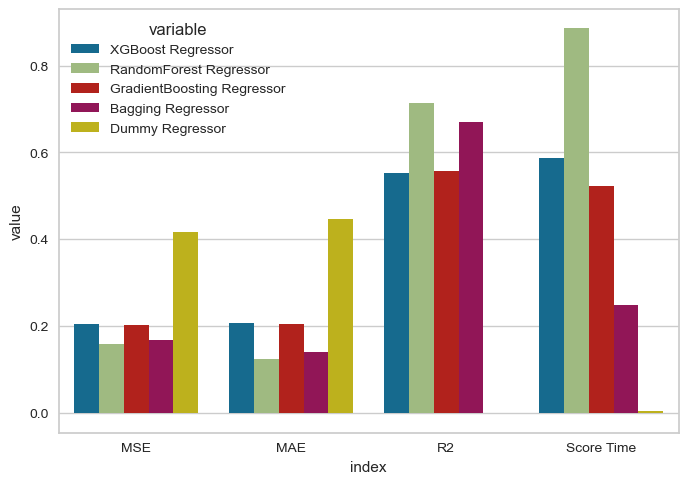

In [147]:
df_bar = models_scores_table_2.drop(['Best Score'],axis=1).reset_index().melt(id_vars=["index"])
sns.barplot(x="index", y="value", hue="variable", data=df_bar)

Le meilleur modèle reste le XGBoost, ce dernier est très performant (R² : 0.89 et RMSE : 0.21). Aussi, l'ENERGYSTARScore est significativement utile. En effet, on observe un baisse significative de nos modèles (avec / sans ENERGYSTARScore). Pour le XGBoost par exemple ce dernier passe de R² = 0.89 avec ENERGYSTARScore à R² = 0.68 sans. Cela montre en définitive l'intérêt très grand de cette variable.